In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
from shapely.geometry import Polygon, Point
from matplotlib import cm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pyslabgrid import nzborders as nzb
from pyslabgrid import mat as mat
from pyslabgrid import slabgridding as slg

#### Slab zones

Plot the (sub)zones!

See the notebook: workout-midslab-zones.

Based on 40 km depth boundary, two sub-zones are defined in each subduction zones.The depths <= 40 km is the shallow (or flat) zone while below 40 km is deep (or steep) zone.

In [2]:
def read_grid(gridfile):
    x,y = [],[]
    with open(gridfile, 'r') as f:
        csvreader = csv.reader(f)
        header = next(csvreader)
        for row in csvreader:
            x.append(float(row[0]))
            y.append(float(row[1])) 
    return x,y

def get_points_inpolgyon(sample_points, blon, blat, assign_nan = False):
    x,y,z = sample_points
    points = np.vstack((x,y)).T 
   # blon, blat = polygon
    tupVerts = []
    for tx,ty in zip(blon, blat):
        tupVerts.append((tx,ty))
    pbounds = Path(tupVerts) # make a polygon
    indx = pbounds.contains_points(points)
    
    if assign_nan:
        kx,ky, kz = [],[],[]
        indx = indx.tolist()
        for xx,yy, zz, dx in zip(x,y,z, indx):
            kx.append(xx)
            ky.append(yy)
            if dx is True:
                kz.append(zz)
            else:
                kz.append(float('nan'))
    else:
        x, y, z  = np.array(x), np.array(y), np.array(z)
        kx, ky, kz  = x[indx].tolist(), y[indx].tolist(), z[indx].tolist()
      
    return(kx,ky,kz)

In [3]:
def plot_zones(surface, pcol='b', ax=None, lw=2):
    folder = 'zone_polygons/'
    fname = 'hik_'+surface+'-zone-flat.csv'
    x,y = read_grid(folder+fname)
    ax.plot(x,y, '--', color=pcol)
    fname = 'hik_'+surface+'-zone-steep.csv'
    x,y = read_grid(folder+fname)
    ax.plot(x,y, '--', color=pcol)
    fname = 'puy_'+surface+'-zone-flat.csv'
    x,y = read_grid(folder+fname)
    ax.plot(x,y, '--', color=pcol)
    fname = 'puy_'+surface+'-zone-steep.csv'
    x,y = read_grid(folder+fname)
    ax.plot(x,y, '--', color=pcol, linewidth=lw)

def plot_whole_zone(szone, ax=None, pcol='b', lw=2):
    folder = 'zone_polygons/'
    x,y = read_grid(folder+szone+'_midslab-zone-whole.csv')
    ax.plot(x,y, '--', color=pcol, linewidth=lw)
    

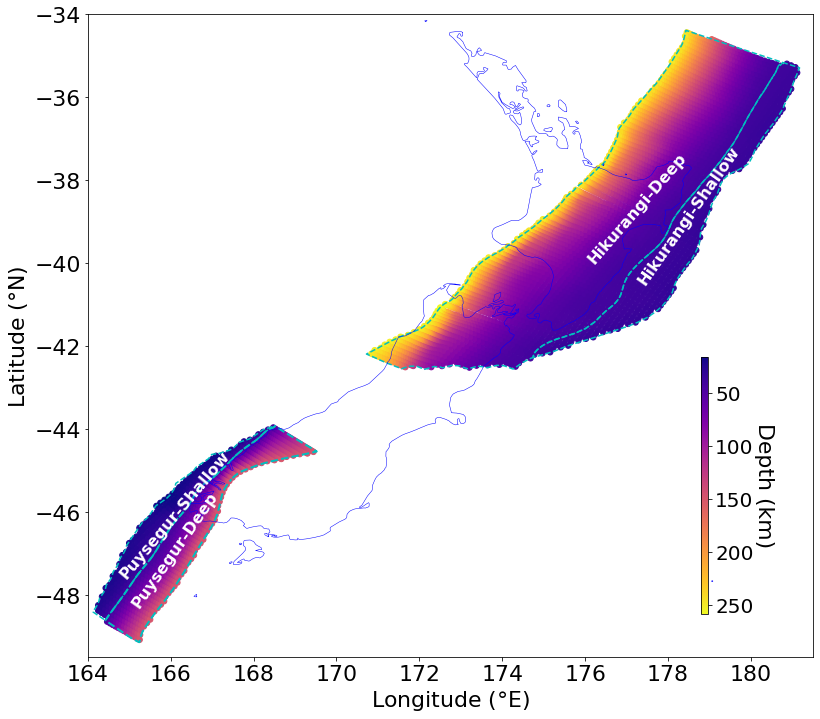

In [4]:
%matplotlib inline
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1,1, figsize=(13,13))
szone = 'hik'
X,Y,Z = slg.compute_slabgrids(szone, None, dx_km=11, doplot=False, clipzone=False)
sheets = slg.get_3sheets(X,Y,Z, szone, depdistr = {'hik': [[17, 29, 40]], 'puy': [[10,15,20]], }\
                         , doplot=False)
X2,Y2,Z2 = sheets['slabq2']
wx,wy = read_grid('zone_polygons/hik_midslab-zone-whole.csv')
hik_gx, hik_gy, hik_gz = get_points_inpolgyon((X2,Y2,Z2), wx,wy)

szone = 'puy'
X,Y,Z = slg.compute_slabgrids(szone, None, dx_km=11, doplot=False, clipzone=False)
sheets = slg.get_3sheets(X,Y,Z, szone, depdistr = {'hik': [[17, 29, 40]], 'puy': [[10,15,20]], }\
                         , doplot=False)
X2,Y2,Z2 = sheets['slabq2']
wx,wy = read_grid('zone_polygons/puy_midslab-zone-whole.csv')
puy_gx, puy_gy, puy_gz = get_points_inpolgyon((X2,Y2,Z2), wx,wy)

#ax.contour(hik_gx, hik_gy, hik_gz, 9, cmap='hot', alpha = 0.9)
sc = ax.scatter(hik_gx+puy_gx,hik_gy+puy_gy, c=hik_gz+puy_gz,\
                plotnonfinite=False, cmap='plasma', s= 30)


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# (x0, y0, width, height
axins = inset_axes(ax, width="1%", height="40%", loc='lower left',
                   bbox_to_anchor=(0.83,0.05, 1,1), bbox_transform=ax.transAxes)
   
cbar = fig.colorbar(sc, cax =axins, shrink=0.4)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('Depth (km)', rotation=270, fontsize=22)
cbar.ax.tick_params(labelsize=20)
cbar.ax.invert_yaxis() 

# cbar = fig.colorbar(sc, shrink=0.2, location="top")
# cbar.ax.get_xaxis().labelpad = 6
# cbar.ax.set_xlabel('depth (km)', rotation=0)

plot_zones('midslab', pcol='c', lw =2, ax =ax)

#
nzb.plot(file = '../pyslabgrid/nzborders.json', plinewidth= 0.5, pcolor = 'b', ax=ax)

ax.text(177.2, -40.5, 'Hikurangi-Shallow', rotation=55, fontsize=16, color='w', fontweight='bold')
ax.text(176, -40, 'Hikurangi-Deep', rotation=49, fontsize=16, color='w', fontweight='bold')

ax.text(165, -48.3, 'Puysegur-Deep', rotation=55, fontsize=16, color='w', fontweight='bold')
ax.text(164.7, -47.6, 'Puysegur-Shallow', rotation=50, fontsize=16, color='w', fontweight='bold')

ax.set_xlim([164, 181.5])
ax.set_ylim([-49.5, -34])
ax.set_xlabel('Longitude ($\xb0$E)', fontsize=22)
ax.set_ylabel('Latitude ($\xb0$N)', fontsize=22)
#ax.axis('off')
ax.set_aspect('equal')


In [5]:
fig.savefig('Figure3.jpeg', dpi=300, facecolor='w');